# RNA Seq Analysis with Python
#### The RNA-Seq data here are all from oligodendrocytes, downloaded from [the Linnarson lab website](http://linnarssonlab.org/oligodendrocytes/). 
The data come from [this paper](https://science.sciencemag.org/content/352/6291/1326.long), and are gene counts that are aligned to the mouse genome.
#### The goals of this notebook will be to:
1. get some data and visualize some gene counts
2. make a t-SNE visualization of the cell types like this one:
![Marquez, Zeisel, et al 2016](./res/oligoTSNE_MarquezZeisel2016.png)
### Marquez, Zeisel et al., Science, 2016
3. cluster the data and use it to color the tSNE visualization

##### Some of the code is pre-written, and you will simply execute it. In other cases, you will be prompted to write some code lines to advance towards this goal. **There are going to be 8 such prompts,** plus some bonus challenges if you want to keep going.
<br>
<br>


#### imports of things we will need for this notebook

In [1]:
import numpy as np
import os,sys,glob
import pandas as pd

load some RNASeq data. we will use ```pandas``` to load the data, creating a ```pandas``` ```DataFrame```. We name this ```DataFrame``` ```df```

In [2]:
df = pd.read_csv('/srv/GSE75330_Marques_et_al_mol_counts2.tab',sep="\t")
df = df.set_index('cellid') # don't worry too much about this; we are making what used to be regular column (cellid) the special "index" column can explain more if needed 

as a reminder, a ```DataFrame``` is fundamentally large table.  we can look at just the top of this table using ```df.head()```

In [ ]:
df.head()

this shows us the rows and columns of ```df```. The rows here in ```df.head``` aren't the most informatively named, but they are gene names. Columns are samples, independent RNA-Seq datasets from mouse oligodenrocytes.  The values are gene counts.
<br> Let's look at the shape of ```df``` this will tell us how many genes and how many oligodendrocytes we have

Let's take a look around the data to convince ourselves we really have oligodenroctye samples. First, let's grab the gene counts for a gene we expect to be expressed in mature oligodenrocytes: Olig1

In [85]:
olig1 = df[df.index=='Olig1']

<br>**First question of this exercise:
<br>Q1: What type of data is ```olig1```? write some code that will give the answer in the cell below:**

A quick trick in pandas for extracting data is ```.values()```. this will return the values of the table into the more flexible ```numpy``` ```ndarray```

In [ ]:
olig1.values[0]

note that we add a ```[0]``` to get just the first list of values. ```.values``` actually returns a list of ```ndarray```s, a useful feature when returning values of more than one row in a table. since ```olig1``` only has one row, we only grab that one.
<br>
<br>
so we have some values for Olig1 counts. how does that compare to something we expect to be low? How about Kcna3, a delayed rectifier channel that shouldn't really be in oligos. We'll start by making sure that these genes are in our data set by searching the ```df``` index for "Kcna" genes

In [ ]:
df.index[df.index.str.startswith('Kcna')] 

yep, Kcna3 is there! 
<br><br>**Q2: Get the counts of Kcna3 across our samples here, and assign these counts, as type ```ndarray```, to the variable ```Kcna3_counts```**

Let's plot Olig1 and Kcna3 across the samples:

In [ ]:
plt.plot(df[df.index=='Olig1'].values[0],color='#cc33ff',label='Olig1')
plt.plot(Kcna3_counts,color='k',label='Knca3')
plt.legend()
plt.ylabel('count');
plt.xlabel('sample')

uh oh, that seems to not work for some reason. 
<br>**Q3: why? make the above plot work.**

if you got the plot to work, it is looking reasonable! many more counts of Olig1 than Kcna3.
<br>**Q4: add Olig2, Olig3, and myelin basic protein (Mbp) to the plot.** _hint_ use flow control, i.e., make a for loop that iterates over the genes we want to add to the plot

Looks like we've got oligos! 
<br><br>
How many types of oligos? Lets try some clustering and visualization

First, we will retype and reshape our table of genes and cells, so that it is an ```ndarray``` that is (cells,genes). This is for use with ```sklearn```, which [wants](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE.fit_transform) the input to be: 
> Parameters: X: array, shape (n_samples, n_features) or (n_samples, n_samples)
If the metric is ‘precomputed’ X must be a square distance matrix. Otherwise it contains a sample per row. If the method is ‘exact’, X may be a sparse matrix of type ‘csr’, ‘csc’ or ‘coo’. If the method is ‘barnes_hut’ and the metric is ‘precomputed’, X may be a precomputed sparse graph.

In [ ]:
data = df.to_numpy().T
print(data.shape)

Now we will do our tSNE embedding. For more on tSNE, check [this out](https://lvdmaaten.github.io/tsne/). We'll use the scikit-learn implentation of tSNE, with parameters from [Marquez, Zeisel et al](https://science.sciencemag.org/content/352/6291/1326.long) (the paper from which we got this data).

In [4]:
import time
from sklearn.manifold import TSNE

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=1000)
tsne_results = tsne.fit_transform(data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Note: this might take a bit of long time to execute. it takes 5 minutes on Dan's laptop. it will print what it is doing as it goes. If you're bored, go read about [scanpy](https://icb-scanpy.readthedocs-hosted.com/en/stable/index.html).

cool, an embedding! This looks pretty similar, but not so much like the figure in the paper. Why? maybe one reason is that we used all of the genes, which could be noisy. Also, we had to use a less exact tSNE method that used in the paper, because the dataset still had all the genes in it.
<br><br>Let's go back to our data, ```data```. Perhaps we can remove noisy genes that aren't highly expressed by any cells in the data. We can sum across all of the cells:

In [18]:
total_counts = data.sum(axis=0)

and see a histogram of these counts. we'll make it a on logarithmic scale so we can see it:

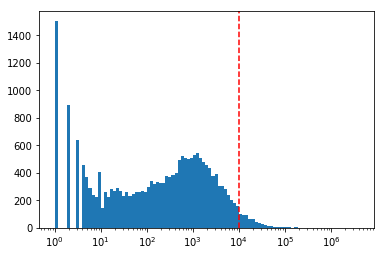

In [30]:
logbins = np.logspace(np.log10(1),np.log10(np.max(total_counts)),100)
plt.hist(total_counts, bins=logbins)
plt.xscale('log')
plt.axvline(np.shape(data)[0]*2,color='r',ls='--')

Let's use a cutoff of total count across all cells of 1.5 <br>
**Q5: find all of the genes that aren't highly expressed. this could be a list of gene names, or it could be an array of indexes in to ```data```**  

**Q6: remove these from ```data```. call this new, reduced version, ```data_subset```** 

In [34]:
data_subset = data[:,indices]

now we'll run our tSNE again, on the subset of data. it'll be much faster!

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:,0],tsne_results[:,1],alpha=0.1,color='k')
plt.xlabel('tSNE 1');plt.ylabel('tSNE 2')

We could also do a tSNE embedding with the more precise method used in Marquez, Zeisel 2016, but this will still take a long while. I have run it here and plotted the results:

In [55]:
time_start = time.time()
tsne = TSNE(n_components=40, verbose=1, learning_rate = 100., perplexity=80, n_iter=1000, metric = 'correlation',method='exact')
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5069
[t-SNE] Computed conditional probabilities for sample 2000 / 5069
[t-SNE] Computed conditional probabilities for sample 3000 / 5069
[t-SNE] Computed conditional probabilities for sample 4000 / 5069
[t-SNE] Computed conditional probabilities for sample 5000 / 5069
[t-SNE] Computed conditional probabilities for sample 5069 / 5069
[t-SNE] Mean sigma: 0.043358
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.986593


KeyboardInterrupt: 

In [ ]:
plt.scatter(tsne_results[:,0],tsne_results[:,1],alpha=0.1,color='k')
plt.xlabel('tSNE 1');plt.ylabel('tSNE 2')
plt.gca().set_aspect(1)#make it a sqaure

Finally, we'll use a nice specialized package made for this kind of analysis (single cell sequencing), ```scanpy```. Note that we could have used this to do the tSNE embedding as well, but we wanted to do at least one thing with a (slightly) less specialized package. 

In [38]:
import scanpy as sc

```scanpy``` has it's own data type, AnnData, which we need to make our data adhere to. 

In [39]:
adata = sc.read_csv('/srv/GSE75330_Marques_et_al_mol_counts2.tab',delimiter='\t')
adata = adata.T

In [40]:
sc.pp.filter_genes(adata,min_counts=np.shape(data)[0]*2)

We'll now do a clustering of the expression to determine how many transciptional cell types we think exist within oligodendrocytes. We'll use the Louvain methods, but others are certainly available. 

In [41]:
sc.pp.neighbors(adata)
sc.tl.louvain(adata) # i suggest looking at the documentaiotn of this!

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/danieljdenman/opt/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


**Q7 How many cell types did we find? call this ```number_of_classes_** 

**Q8: Make a heatmap of expression, grouped by these classes** _hint: use the [```scanpy``` documentation](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.plotting.html)!_

Below is a heatmap with the 500 highest expressing genes, as an example

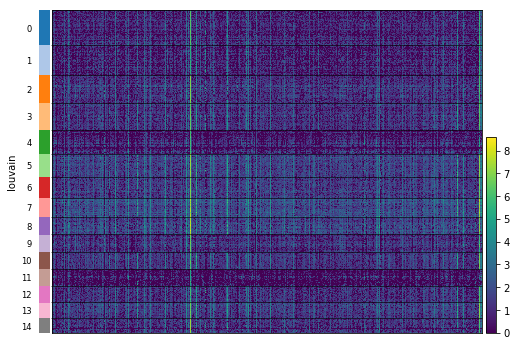

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 8, 0, 0.2])

Finally, let's annotate (color) our tSNE embedding with the results of our clustering, like the example plot at the top. First, we'll import some plotting tools, and make sure our colors match the scanpy colors above. If your are interested in color palettes and color control for this plot, checkout the ```seaborn``` package's [color documentation](https://seaborn.pydata.org/tutorial/color_palettes.html), and its ```set_pallete```, ```color_palette``` and ```palplot```.

In [54]:
from utils import cleanAxes
from seaborn import scatterplot, set_palette
from matplotlib import cm, colors
vega_20 = list(map(colors.to_hex, cm.tab20.colors)) # this is from scanpy's color_pallets.py, so we know it matches
set_palette(vega_20)
# order=np.array([6,8,1,11,10,12,14,0,2,9,13,5,3,4,7]).astype(str) # this order was read directly off of the heatmap above.

In [ ]:
plt.figure(figsize=(8,8))
for i,cell_type in enumerate(np.arange(number_of_classes).astype(str)):
    indices = np.where(np.array(adata.obs['louvain'].values) == cell_type)[0]
    scatterplot(tsne_results[indices,0],tsne_results[indices,1],label=cell_type,legend='full')#,hue=color_palette()[i],)

we did it! a colored tSNE embedding!

**Bonus Qs: <br>Which of these 15 categories corresponds to the 14 categories in Marquez, Ziesel 2016, shown at the top? It looks like our labels 4 and 11 are precursors or newly formed, from the heatmap and tSNE embedding.<br>To answer this more directly, determine which genes are enriched in each of our 15 categories**